In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import psutil
import torch
from datetime import datetime
import time
import pandas as pd
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print(device)

In [2]:
timestamps = []
cpu_ram_mb = []
cpu_ram_percent = []
gpu_ram_mb = []
gpu_ram_percent = []



# --- System Utilization ---------------------------------------------------------------------------
def get_system_utilization():
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    cpu_ram = psutil.virtual_memory()
    cpu_ram_utilization_bytes = cpu_ram.used
    cpu_ram_utilization_mb = cpu_ram_utilization_bytes / (1024 * 1024)
    cpu_ram_percentage = cpu_ram.percent

    gpu_ram_utilization_mb = None
    gpu_ram_percentage = None
    if torch.cuda.is_available():
        gpu_ram_utilization_bytes = torch.cuda.memory_allocated()
        gpu_ram_utilization_mb = gpu_ram_utilization_bytes / (1024 * 1024)
        gpu_ram_total_bytes = torch.cuda.get_device_properties(0).total_memory
        gpu_ram_percentage = (gpu_ram_utilization_bytes / gpu_ram_total_bytes) * 100

    return {
        "time": current_time,
        "cpu_ram_utilization_mb": cpu_ram_utilization_mb,
        "cpu_ram_percentage": cpu_ram_percentage,
        "gpu_ram_utilization_mb": gpu_ram_utilization_mb,
        "gpu_ram_percentage": gpu_ram_percentage
    }



def update_utilization_lists():
    global timestamps, cpu_ram_mb, cpu_ram_percent, gpu_ram_mb, gpu_ram_percent

    utilization = get_system_utilization()

    timestamps.append(utilization["time"])
    cpu_ram_mb.append(utilization["cpu_ram_utilization_mb"])
    cpu_ram_percent.append(utilization["cpu_ram_percentage"])
    gpu_ram_mb.append(utilization["gpu_ram_utilization_mb"])
    gpu_ram_percent.append(utilization["gpu_ram_percentage"])

In [3]:
datadir = r"/home/23m1521/datasets/CelebA"
dfpath = r"/home/23m1521/ashish/MTP/DDPM/CeleabA.parquet"

def walkDIR(folder_path, include=None):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if include is None or any(file.endswith(ext) for ext in include):
                file_list.append(os.path.join(root, file))
    print("Files found:", len(file_list))
    return file_list

# files = walkDIR(datadir, include=['.png', '.jpeg', '.jpg'])
# df = pd.DataFrame(files, columns=['image_path'])
# df['id'] = df['image_path'].apply(lambda x: os.path.basename(x))
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = pd.read_parquet(dfpath).sample(frac=0.04, random_state=42).reset_index(drop=True)
df

image_path          id
0     /home/23m1521/datasets/CelebA/img_align_celeba...  013672.jpg
1     /home/23m1521/datasets/CelebA/img_align_celeba...  055563.jpg
2     /home/23m1521/datasets/CelebA/img_align_celeba...  145628.jpg
3     /home/23m1521/datasets/CelebA/img_align_celeba...  192398.jpg
4     /home/23m1521/datasets/CelebA/img_align_celeba...  049887.jpg
...                                                 ...         ...
8099  /home/23m1521/datasets/CelebA/img_align_celeba...  010392.jpg
8100  /home/23m1521/datasets/CelebA/img_align_celeba...  099050.jpg
8101  /home/23m1521/datasets/CelebA/img_align_celeba...  048895.jpg
8102  /home/23m1521/datasets/CelebA/img_align_celeba...  142243.jpg
8103  /home/23m1521/datasets/CelebA/img_align_celeba...  034314.jpg

[8104 rows x 2 columns]

In [4]:

class CelebADataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data,
        im_size
    ):
        if isinstance(data, str):
            self.data = pd.read_csv(data)
        elif isinstance(data, pd.DataFrame):
            self.data = data
        else:
            raise ValueError("The `data` argument must be a string (CSV file path) or a Pandas DataFrame.")
        
        self.im_size = im_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']

        image = tv.io.decode_image(image_path, mode='RGB')
        image = v2.Resize((self.im_size,self.im_size))(image)
        image = v2.ToDtype(torch.float32, scale=True)(image)
        # image = 2*image - 1

        return image


dataset = CelebADataset(df, im_size=128)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True,
    num_workers=4,
    pin_memory=False,
    drop_last=True,
    persistent_workers=True
)

# for batch in tqdm(dataloader):
#     pass

# images = next(iter(dataloader))
# images = images.to(device)

### Normal Model Training

In [5]:
# --- Define the VAE model -------------------------------------------------------------------------
class CnnVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(CnnVAE, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder -------------------------------------------------------------------
        self.encoder_conv = nn.Sequential(
            # Layer 1: 3x128x128 -> 32x64x64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 32x64x64 -> 64x32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 128x16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 128x16x16 -> 256x8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flattened_size = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder -------------------------------------------------------------------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            # Layer 1: 256x8x8 -> 128x16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 128x16x16 -> 64x32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 32x64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 32x64x64 -> 3x128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 8, 8)
        return self.decoder_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# --- Loss function --------------------------------------------------------------------------------
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD

# --- Initialize model, optimizer ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnVAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Model Parameters:", sum(p.numel() for p in model.parameters()))



# --- Training loop --------------------------------------------------------------------------------
def train(epoch):
    model.train()
    train_loss = 0
    
    for _, (data) in enumerate(tqdm(dataloader)):
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")



# --- Train for 10 epochs --------------------------------------------------------------------------
for epoch in trange(1,4):
    train(epoch)

Model Parameters: 7688131


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 27785.1372


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 25811.4981


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 25385.4499


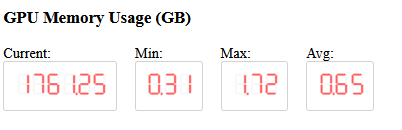

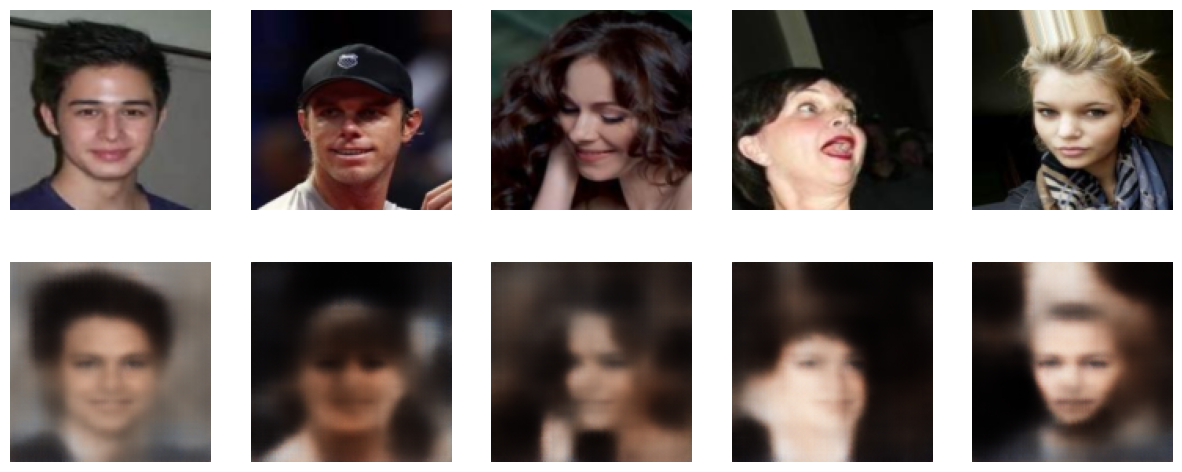

In [9]:
def visualize_reconstructions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))
        data = data.to(device)
        recon_data, _, _ = model(data)

        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0))
            axes[0, i].axis("off")
            axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0))
            axes[1, i].axis("off")
        plt.show()

visualize_reconstructions(model, dataloader, device)

### Applying *Activation Checkpointing*

In [5]:
from torch.utils.checkpoint import checkpoint

class CnnVAE2(nn.Module):
    def __init__(self, latent_dim=128):
        super(CnnVAE2, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder -------------------------------------------------------------------
        self.encoder_conv = nn.Sequential(
            # Layer 1: 3x128x128 -> 32x64x64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 32x64x64 -> 64x32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 128x16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 128x16x16 -> 256x8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flattened_size = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder -------------------------------------------------------------------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            # Layer 1: 256x8x8 -> 128x16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 128x16x16 -> 64x32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 32x64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 32x64x64 -> 3x128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        # Manually checkpoint the encoder_conv layers
        h = checkpoint(self.encoder_conv, x, use_reentrant=False)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 8, 8)
        # Manually checkpoint the decoder_conv layers
        return checkpoint(self.decoder_conv, h, use_reentrant=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# --- Loss function --------------------------------------------------------------------------------
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD

# --- Initialize model, optimizer ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnVAE2(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# --- Training loop --------------------------------------------------------------------------------
def train(epoch):
    model.train()
    train_loss = 0
    
    for _, (data) in enumerate(tqdm(dataloader)):
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")



# --- Train for 10 epochs --------------------------------------------------------------------------
for epoch in trange(1,4):
    train(epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 27522.2222


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 25749.6876


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 25347.2447


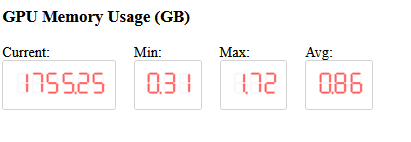

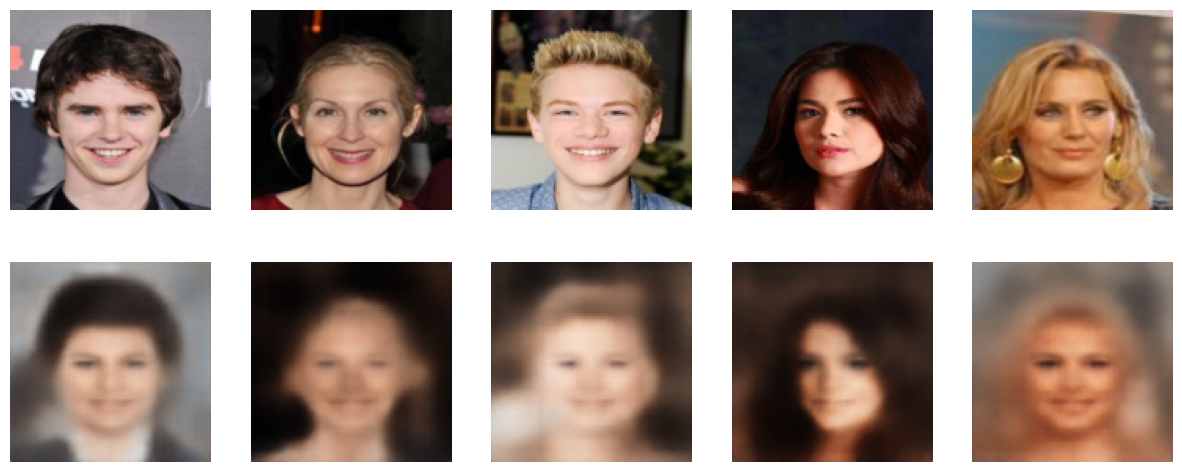

In [7]:
def visualize_reconstructions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))
        data = data.to(device)
        recon_data, _, _ = model(data)

        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0))
            axes[0, i].axis("off")
            axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0))
            axes[1, i].axis("off")
        plt.show()

visualize_reconstructions(model, dataloader, device)

### Applying *Activation Checkpointing* to individual layer

In [5]:
class CnnVAE2(nn.Module):
    def __init__(self, latent_dim=128):
        super(CnnVAE2, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder -------------------------------------------------------------------
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flattened_size = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder -------------------------------------------------------------------
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = checkpoint(self.encoder_conv, x, use_reentrant=False)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_fc(z))
        h = h.view(h.size(0), 256, 8, 8)
        return checkpoint(self.decoder_conv, h, use_reentrant=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# --- Loss function --------------------------------------------------------------------------------
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD

# --- Initialize model, optimizer ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnVAE2(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# --- Training loop --------------------------------------------------------------------------------
def train(epoch):
    model.train()
    train_loss = 0
    
    for _, (data) in enumerate(tqdm(dataloader)):
        data.requires_grad_(True)
        data = data.to(device)


        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")



# --- Train for 10 epochs --------------------------------------------------------------------------
for epoch in trange(1,4):
    train(epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 27577.8545


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 25759.0175


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 25299.4709


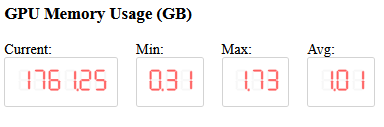
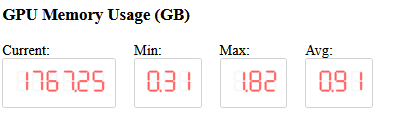
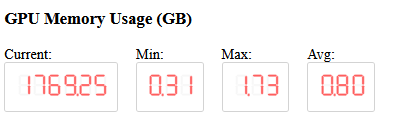

### Applying *Activation Sequential Checkpointing*

In [6]:
from torch.utils.checkpoint import checkpoint_sequential

# --- Define the VAE model -------------------------------------------------------------------------
class CnnVAE2(nn.Module):
    def __init__(self, latent_dim=128):
        super(CnnVAE2, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder -------------------------------------------------------------------
        self.encoder_conv = nn.Sequential(
            # Layer 1: 3x128x128 -> 32x64x64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 32x64x64 -> 64x32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 128x16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 128x16x16 -> 256x8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flattened_size = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder -------------------------------------------------------------------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            # Layer 1: 256x8x8 -> 128x16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 128x16x16 -> 64x32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 64x32x32 -> 32x64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 4: 32x64x64 -> 3x128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        h = checkpoint_sequential(self.encoder_conv, len(self.encoder_conv), x, use_reentrant=False)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 8, 8)
        return checkpoint_sequential(self.decoder_conv, len(self.decoder_conv), h, use_reentrant=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
# --- Loss function --------------------------------------------------------------------------------
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD

# --- Initialize model, optimizer ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnVAE2(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# --- Training loop --------------------------------------------------------------------------------
def train(epoch):
    model.train()
    train_loss = 0
    
    for _, (data) in enumerate(tqdm(dataloader)):
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")



# --- Train for 10 epochs --------------------------------------------------------------------------
for epoch in trange(1,4):
    train(epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 27594.4348


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 25786.6768


  0%|          | 0/506 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 25353.1348


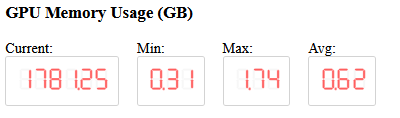

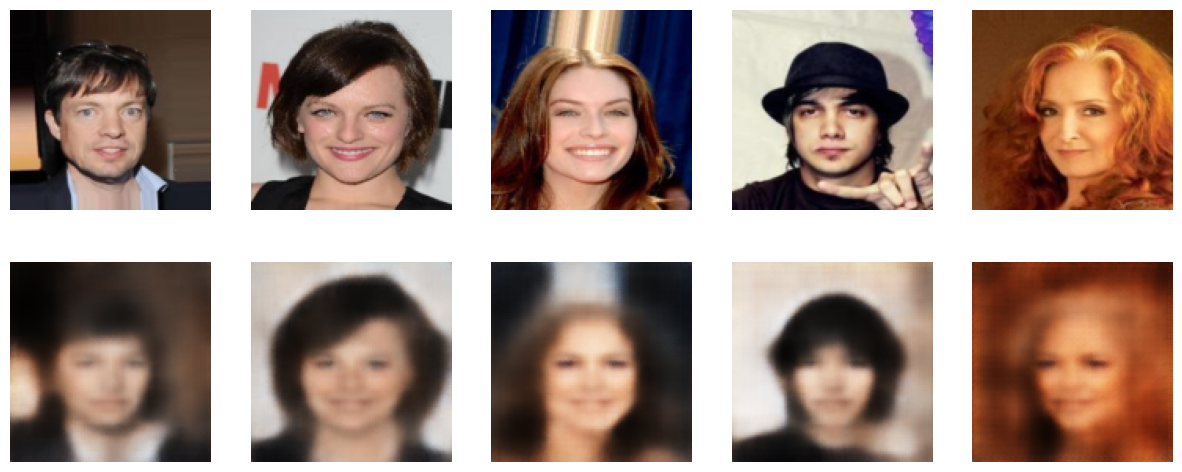

In [8]:
def visualize_reconstructions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))
        data = data.to(device)
        recon_data, _, _ = model(data)

        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0))
            axes[0, i].axis("off")
            axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0))
            axes[1, i].axis("off")
        plt.show()

visualize_reconstructions(model, dataloader, device)